# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={'CAMEO_DEUG_2015': str, 'CAMEO_INTL_2015':str})
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={'CAMEO_DEUG_2015': str, 'CAMEO_INTL_2015':str})

MemoryError: Unable to allocate 632. MiB for an array with shape (93, 891221) and data type int64

In [ ]:
# AZDIAS shape
azdias.shape

In [ ]:
# COSTUMERS shape
customers.shape

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
#azdias_part = azdias.sample(10000)
#customers_part = customers.sample(10000)

In [ ]:
# Replace wrong data
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('\D', '-1', regex=True)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('\D+', '-1', regex=True)

customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].replace('\D', '-1', regex=True)
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].replace('\D+', '-1', regex=True)

In [ ]:
# Id of each group
others_id = azdias['LNR'].unique()
customers_id = customers['LNR'].unique()

In [ ]:
# Analyse Customers
customer_features = customers[['LNR','CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]
customer_features.info() # There is no null values

In [ ]:
# Analyse Customers - Univariate Exploration
base_color = sns.color_palette()

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.countplot(data=customer_features, x='CUSTOMER_GROUP', color=base_color[3]);
plt.title("CUSTOMER GROUP");
plt.xlabel("");
plt.ylabel("");
plt.ylim([0, 180000]);

plt.subplot(1,3,2)
sns.countplot(data=customer_features, x='ONLINE_PURCHASE', color=base_color[0]);
plt.title("ONLINE PURCHASE");
plt.xlabel("");
plt.ylabel("");
plt.ylim([0, 180000]);

plt.subplot(1,3,3)
sns.countplot(data=customer_features, x='PRODUCT_GROUP', color=base_color[4]);
plt.title("PRODUCT GROUP");
plt.xlabel("");
plt.ylabel("");
plt.ylim([0, 180000]);

plt.savefig('univariate.png', format='png')


In [ ]:
# CUSTOMER GROUP
customer_group = customer_features['CUSTOMER_GROUP'].value_counts() / customer_features['CUSTOMER_GROUP'].value_counts().sum()

multi_buyer = customer_group.values[0]*100
single_buyer = customer_group.values[1]*100

print("percentage of multi buyer: {:2.1f} % ".format(multi_buyer))
print("percentage of single buyer: {:2.1f} % ".format(single_buyer))
print("\n")

# ONLINE PURCHASE GROUP
online_purchase = customer_features['ONLINE_PURCHASE'].value_counts() / customer_features['ONLINE_PURCHASE'].value_counts().sum()

non_online = online_purchase.values[0]*100
online = online_purchase.values[1]*100

print("percentage of non_online: {:2.1f} % ".format(non_online))
print("percentage of online: {:2.1f} % ".format(online))
print('\n')

# PRODUCT GROUP
product_group = customer_features['PRODUCT_GROUP'].value_counts() / customer_features['PRODUCT_GROUP'].value_counts().sum()

cosmetic_food = product_group.values[0]*100
food = product_group.values[1]*100
cosmetic = product_group.values[2]*100

print("percentage of COSMETIC_AND_FOOD group: {:2.1f} % ".format(cosmetic_food))
print("percentage of FOOD: {:2.1f} % ".format(food))
print("percentage of COSMETIC: {:2.1f} % ".format(cosmetic))

print('\n')

In [ ]:
# Analyse Customers - Bivariate Exploration

# CUSTOMER_GROUP vs ONLINE_PURCHASE
plt.figure(figsize=(10,3));
plt.subplot(1,2,1)
sns.countplot(data=customer_features, x='CUSTOMER_GROUP', hue='ONLINE_PURCHASE');
plt.ylabel("");
plt.xlabel("");
plt.title('CUSTOMER GROUP');

plt.subplot(1,2,2)
sns.countplot(data=customer_features, x='ONLINE_PURCHASE', hue='CUSTOMER_GROUP');
plt.ylabel("");
plt.xlabel("");
plt.title('ONLINE PURCHASE');

plt.savefig('bivariate1.png', format='png')


>- A maior parte dos clientes são os multi-compradores que não compram online.

In [ ]:
# Analyse Customers - Bivariate Exploration

# CUSTOMER_GROUP vs PRODUCT_GROUP
plt.figure(figsize=(10,3));
plt.subplot(1,2,1)
sns.countplot(data=customer_features, x='CUSTOMER_GROUP', hue='PRODUCT_GROUP');
plt.ylabel("");

plt.subplot(1,2,2)
sns.countplot(data=customer_features, x='PRODUCT_GROUP', hue='CUSTOMER_GROUP');
plt.ylabel("");
plt.savefig('bivariate2.png', format='png')


>- A maior parte dos clientes são multi-compradores que compram cosméticos e comida.


In [ ]:
# Analyse Customers - Bivariate Exploration

# PRODUCT_GROUP" vs "ONLINE_PURCHASE"
plt.figure(figsize=(10,3));
plt.subplot(1,2,1)
sns.countplot(data=customer_features, x='ONLINE_PURCHASE', hue='PRODUCT_GROUP');
plt.ylabel("");
plt.savefig('bivariate3.png', format='png')


**Online purchase**

>- A maior parte dos clientes compram cosméticos & comida.

**Non-online purchase**

>- Os clientes estão distruibuídos de forma mais uniforme entre os grupos de produtos.


In [ ]:
# Gather general and customer data in a dataset

total_df = pd.concat([azdias, customers], axis=0, join='inner')

# Drop columns with object type - verificar se usarei

aux = (total_df.dtypes=='object')
obj_cols = aux[aux].index.values

#total_df = total_df.set_index('LNR')
#total_df = total_df.drop(columns=obj_cols)


In [ ]:
# Verify the quantity of values in each categoric column
obj_values = {col: customers[col].nunique() for col in obj_cols}
obj_values    
    

In [ ]:
# Create a function that remove columns with 90% nan values

def drop_na_columns(df, na_perct=.9):
    
    '''Drop columns with missing values when they represent 90 percent of the rows and return it. 
    
    inputs
    na_perct(float): the percentage of missing values in a column.
    df(pandas DataFrame): the DataFrame
    
    output
    new_df(pandas DataFrame): the DataFrame after columns dropped.
    
    
    '''
    drop_cols = df.isnull().sum() / df.shape[0]
    labels = drop_cols[drop_cols>=na_perct].index.values
    new_df = df.drop(labels=labels, axis=1 )
    
    return new_df
    
    
def drop_na_rows(df, na_perct=.9):
    
    '''Drop rows with missing values when they represent 90 percent of the rows and return it. 
    
    inputs
    na_perct(float): the percentage of missing values in a row.
    df(pandas DataFrame): the DataFrame
    
    output
    new_df(pandas DataFrame): the DataFrame after rows dropped.
    
    
    '''
    
    thresh = np.ceil(na_perct * df.shape[1])
    new_df = df.dropna(axis=0, thresh=thresh)
    
    return new_df

def drop_invariability(df, na_perct=0.9):
    '''
    '''
    cols = df.columns
    no_var_cols = []
    new_df = df
    
    for col in cols:
        aux = df[col].value_counts() / df[col].value_counts().sum()
        if np.sum(aux >= na_perct) > 0:
            new_df = new_df.drop(labels=col, axis=1)
            
    return new_df
            
        
        


In [ ]:
total_df = drop_na_columns(df=total_df, na_perct=0.7)
total_df = drop_na_rows(df=total_df, na_perct=0.7)
total_df = drop_invariability(total_df, na_perct=0.9)

total_df.reset_index(drop=True, inplace=True)


In [ ]:
obj_cols = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
total_df = total_df.drop(columns=obj_cols)

In [ ]:
total_df.head()

In [ ]:
# Columns and dataframe with missing values
aux = total_df.isnull().sum().sort_values()
cols_with_missing = aux[aux>0]
cols_with_missing = cols_with_missing.index.values

for col in cols_with_missing:
    if total_df[col].isnull().sum() > 0.1*total_df.shape[0]:
            total_df[col+'_was_missing'] = total_df[col].isnull()

In [ ]:
total_df.head()

In [ ]:
total_df['OST_WEST_KZ'] = pd.get_dummies(total_df['OST_WEST_KZ'], prefix='OST_WEST_KZ', drop_first=True)

In [ ]:
my_imputer1 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputed_df = pd.DataFrame(my_imputer1.fit_transform(total_df))
imputed_df.columns = total_df.columns

In [ ]:
imputed_df.isnull().sum().sum()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
X = imputed_df.set_index('LNR').astype(np.int8)
X.info()

In [ ]:
X = pd.read_csv("total_df.csv")

In [ ]:
X = X.set_index('LNR').astype(np.int8)

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.cluster import KMeans

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#X.to_csv('imputed_df.csv')

In [ ]:
# Id after cleaning data
others_id = np.intersect1d(others_id, imputed_df['LNR'].unique())
customers_id = np.intersect1d(customers_id, imputed_df['LNR'].unique())

In [ ]:
# K-means
X_customers = X.loc[customers_id,:]
X_others = X.loc[others_id,:]

In [ ]:
# Choosing the best number of clusters

wcss = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=500)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    

In [ ]:
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(np.arange(2,15), wcss, linewidth=2, color='red', marker='8')
plt.xlabel('Number of clusters')
plt.xticks(range(2,15))
plt.ylabel("");
plt.title("Within-Cluster-Sum-of-Squares (WCSS)");

plt.savefig('wcss.png', format='png')



In [9]:
# Clustering
kmeans = KMeans(n_clusters=6, random_state=42, max_iter=500)
kmeans.fit(X)

KMeans(max_iter=500, n_clusters=6, random_state=42)

In [10]:
# Assign cluster to each person
y= kmeans.predict(X)
X['cluster'] = y

In [245]:
# Assign cluster to each group
y_customers = kmeans.predict(X_customers)
X_customers['cluster'] = y_customers

y_others = kmeans.predict(X_others)
X_others['cluster'] = y_others

In [246]:
X_others['cluster'].value_counts() / X_others['cluster'].value_counts().sum()

4    0.204926
0    0.201987
1    0.200299
3    0.197277
2    0.195511
Name: cluster, dtype: float64

In [247]:
X_customers['cluster'].value_counts() / X_customers['cluster'].value_counts().sum()

4    0.230140
0    0.225510
1    0.221463
3    0.162633
2    0.160254
Name: cluster, dtype: float64

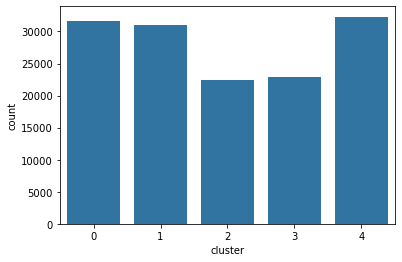

In [248]:
sns.countplot(data=X_customers, x='cluster', color=base_color[0]);


- Há maior concentração de clientes nos clusters 4, 2 e 1

In [249]:
#from sklearn.metrics.cluster import silhouette_score

#metric = silhouette_score(X, kmeans.predict(X))
#metric

In [250]:
# OPTICS
#from sklearn.cluster import OPTICS
#eps = 75
#min_samples = 2*X.shape[1]-2

#optics = OPTICS(eps=eps, min_samples=min_samples)
#clustering_labels = optics.fit_predict(X)
#clustering_labels.unique()


In [251]:
#from sklearn.cluster import DBSCAN
#from sklearn.neighbors import NearestNeighbors

#neighbors = NearestNeighbors(n_neighbors=2*X.shape[1])
#neighbors_fit = neighbors.fit(X)
#distances, indices = neighbors_fit.kneighbors(X)

#distances = np.sort(distances, axis=0)
#distances = distances[:,1]
#plt.plot(distances)

In [252]:
#plt.plot(distances)
#plt.xlim(924000,925795)
#plt.ylim(40,60)

In [253]:
# DBSCAN

#eps = 50
#min_samples = 2*X.shape[1]

#dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#clustering_labels = dbscan.fit_predict(X)
#clustering_labels.unique()


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [254]:
mailout = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={'CAMEO_DEUG_2015': str, 'CAMEO_INTL_2015':str})


In [255]:
# Prepare data
X_new = mailout[['LNR'] + np.intersect1d(mailout.columns, X_customers.columns).tolist()]

In [256]:
# Clean data - Drop missing values
#X_new = drop_na_columns(df=X_new, na_perct=0.7)
X_new2 = drop_na_rows(df=X_new, na_perct=0.7)
#X_new = drop_invariability(X_new, na_perct=0.9)

X_new2.isnull().sum().sum()

103340

In [257]:
X_clean = X_new2.copy()

In [258]:
#cols_missing = np.setdiff1d(X_customers.columns, X_new2.columns)

In [259]:
cols_missing = ['ALTERSKATEGORIE_FEIN', 'D19_GESAMT_ONLINE_QUOTE_12',
               'D19_KONSUMTYP', 'D19_LOTTO','D19_SOZIALES', 
                'D19_VERSAND_ONLINE_QUOTE_12', 'EXTSEL992','KK_KUNDENTYP']

In [260]:
# Columns and dataframe with missing values
for col in cols_missing:
    X_clean[col+'was_missing'] = X_new2[col].isnull()
    

In [261]:
X_clean.shape

(35000, 336)

In [262]:
X_clean['OST_WEST_KZ'] = pd.get_dummies(X_clean['OST_WEST_KZ'], prefix='OST_WEST_KZ', drop_first=True)

In [263]:
# Imputation

my_imputer2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputed_X_clean = pd.DataFrame(my_imputer2.fit_transform(X_clean))
imputed_X_clean.columns = X_clean.columns

#imputed_X_clean = imputed_X_clean.astype(np.int8)

imputed_X_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Columns: 336 entries, LNR to KK_KUNDENTYPwas_missing
dtypes: object(336)
memory usage: 89.7+ MB


In [264]:
imputed_X_clean.isnull().sum().sum()

0

In [265]:
X_end = imputed_X_clean.set_index("LNR").astype(np.int8)

In [266]:
ids = np.intersect1d(X_end.index,mailout['LNR'].unique())

In [267]:
#X = drop_invariability(X, na_perct=0.9)
y = mailout.set_index('LNR').loc[ids,'RESPONSE']
X = X_end.loc[ids,:]

In [268]:
X['cluster'] = kmeans.predict(X)

In [269]:
X.head()

,AGER_TYP,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,ZABEOTYP,ALTERSKATEGORIE_FEINwas_missing,D19_GESAMT_ONLINE_QUOTE_12was_missing,D19_KONSUMTYPwas_missing,D19_LOTTOwas_missing,D19_SOZIALESwas_missing,D19_VERSAND_ONLINE_QUOTE_12was_missing,EXTSEL992was_missing,KK_KUNDENTYPwas_missing,cluster
LNR,,,,,,,,,,,,,,,,,,,,,
11,-1,1,15,4,15,2,1,3,1,1,...,2,0,0,0,0,0,0,1,0,2
13,2,1,10,4,10,2,4,0,2,4,...,3,0,0,0,0,0,0,0,1,3
14,1,1,12,3,12,2,2,0,2,2,...,3,0,0,0,0,0,0,0,0,3
48,0,1,8,4,8,2,2,0,0,3,...,3,0,0,0,0,0,0,1,1,3
132,-1,1,0,4,0,2,1,0,1,1,...,3,0,0,0,0,0,0,0,0,2


In [270]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier

In [177]:
# Split samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [196]:
xgb = XGBClassifier(n_estimators=300, learning_rate=1.9, max_depth=2, objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1.9, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [197]:
y_pred = xgb.predict(X_train)
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99     27660
     class 1       0.46      0.05      0.09       340

    accuracy                           0.99     28000
   macro avg       0.72      0.52      0.54     28000
weighted avg       0.98      0.99      0.98     28000



In [198]:
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      6905
     class 1       0.00      0.00      0.00        95

    accuracy                           0.98      7000
   macro avg       0.49      0.50      0.50      7000
weighted avg       0.97      0.98      0.98      7000



In [199]:
# Preprocessing
#scaler_train = StandardScaler().fit(X_train)
scaler_train = MinMaxScaler().fit(X_train)
X_train = scaler_train.transform(X_train)

#scaler_test = StandardScaler().fit(X_test)
scaler_test = MinMaxScaler().fit(X_test)
X_test = scaler_train.transform(X_test)

In [200]:
# SVM
from sklearn.svm import LinearSVC, SVC
svm = SVC(kernel='poly', class_weight='balanced', random_state=42, C=0.3).fit(X_train, y_train)

In [201]:
y_pred = svm.predict(X_train)
print(classification_report(y_train, y_pred, target_names=target_names))
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     27660
     class 1       0.91      1.00      0.95       340

    accuracy                           1.00     28000
   macro avg       0.95      1.00      0.98     28000
weighted avg       1.00      1.00      1.00     28000

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      6905
     class 1       0.03      0.01      0.02        95

    accuracy                           0.98      7000
   macro avg       0.51      0.50      0.50      7000
weighted avg       0.97      0.98      0.98      7000



## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [276]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={'CAMEO_DEUG_2015': str, 'CAMEO_INTL_2015':str})

In [277]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


In [284]:
mailout_test.isnull().sum()

LNR                         0
AGER_TYP                    0
AKT_DAT_KL               6889
ALTER_HH                 6889
ALTER_KIND1             40820
                        ...  
WOHNDAUER_2008           6889
WOHNLAGE                 7627
ZABEOTYP                    0
ANREDE_KZ                   0
ALTERSKATEGORIE_GROB        0
Length: 366, dtype: int64